# VSM (Vector Space Model) Implementation

This notebook implements a basic VSM model following the requirements:
1. Introduction to VSM model
2. Term selection methodology
3. Term weight calculation formula (TF-IDF)
4. Index creation
5. Query processing
6. Evaluation on Cranfield dataset using P, R and MAP metrics


In [12]:
# Import necessary libraries
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import ir_datasets
from itertools import islice

# Additional imports for preprocessing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Load Cranfield dataset using ir_datasets
dataset = ir_datasets.load("cranfield")

print("Libraries imported successfully!")
print("Cranfield dataset loaded!")


Libraries imported successfully!
Cranfield dataset loaded!


## 1. Giới thiệu mô hình VSM (Vector Space Model)

**VSM (Vector Space Model)** là một mô hình đại số trong lĩnh vực truy xuất thông tin (Information Retrieval) được sử dụng để:

### Phương pháp biễu diễn tài liệu và truy vấn:
- **Vector Representation**: Biểu diễn tài liệu và truy vấn dưới dạng vector trong không gian nhiều chiều
- **Term Weighting**: Sử dụng TF-IDF để tính trọng số cho mỗi term
- **Cosine Similarity**: Đo độ tương đồng giữa vector tài liệu và vector truy vấn

### Nguyên tắc tính toán độ liên quan để xếp hạng:
1. **Document Vector**: Mỗi tài liệu được biểu diễn như một vector với các chiều là terms
2. **Query Vector**: Truy vấn cũng được biểu diễn tương tự như document vector
3. **Similarity Calculation**: Sử dụng cosine similarity để tính độ tương đồng
4. **Ranking**: Xếp hạng tài liệu theo thứ tự giảm dần của độ tương đồng

### Ưu điểm của VSM:
- Đơn giản và dễ hiểu
- Hiệu quả tính toán
- Khả năng xử lý partial matching
- Kết quả ranked retrieval thay vì boolean


In [13]:
# Load Cranfield dataset using ir_datasets
documents = {}
queries = {}

# Load documents
for doc in dataset.docs_iter():
    documents[str(doc.doc_id)] = doc.text

# Load queries  
for query in dataset.queries_iter():
    queries[str(query.query_id)] = query.text

print(f"Loaded {len(documents)} documents")
print(f"Loaded {len(queries)} queries")
print("\nFirst few document IDs:", list(documents.keys())[:5])
print("\nFirst query:")
print(f"Query 1: {queries.get('1', 'Not found')}")
print("\nFirst document:")
print(f"Document 1: {documents.get('1', 'Not found')[:200]}...")


Loaded 1400 documents
Loaded 225 queries

First few document IDs: ['1', '2', '3', '4', '5']

First query:
Query 1: what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .

First document:
Document 1: experimental investigation of the aerodynamics of a
wing in a slipstream .
  an experimental study of a wing in a propeller slipstream was
made in order to determine the spanwise distribution of the l...


## 2. Chọn term: Phương pháp xác định và ví dụ minh họa

### Term được chọn là gì?
**Term** trong mô hình VSM là các đơn vị từ vựng cơ bản được sử dụng để biểu diễn nội dung tài liệu và truy vấn trong không gian vector.

### Phương pháp xác định term:

1. **Tokenization**: Tách văn bản thành các từ riêng lẻ
2. **Lowercasing**: Chuyển tất cả về chữ thường
3. **Stop word removal**: Loại bỏ các từ không mang ý nghĩa (a, an, the, is, are...)
4. **Stemming/Lemmatization**: Đưa về dạng gốc của từ
5. **Filtering**: Loại bỏ từ quá ngắn, số, ký tự đặc biệt

### Ví dụ minh họa quá trình xác định term:


In [14]:
# Text preprocessing function
def preprocess_text(text):
    """
    Preprocess text by tokenizing, removing stopwords, and stemming
    """
    # Initialize stemmer and stopwords
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase and tokenize
    text = text.lower()
    tokens = word_tokenize(text)
    
    # Remove punctuation, numbers, and short words
    tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stem words
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

# Example demonstration of term selection process
sample_text = "experimental investigation of the aerodynamics of a wing in a slipstream"
print("Original text:")
print(f"'{sample_text}'")
print("\nStep-by-step term extraction process:")

# Step 1: Tokenization and lowercasing
tokens = word_tokenize(sample_text.lower())
print(f"1. Tokenization: {tokens}")

# Step 2: Remove punctuation and short words
filtered_tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
print(f"2. Filter alpha and length > 2: {filtered_tokens}")

# Step 3: Remove stopwords
stop_words = set(stopwords.words('english'))
no_stopwords = [token for token in filtered_tokens if token not in stop_words]
print(f"3. Remove stopwords: {no_stopwords}")

# Step 4: Stemming
stemmer = PorterStemmer()
stemmed = [stemmer.stem(token) for token in no_stopwords]
print(f"4. Stemming: {stemmed}")

print(f"\nFinal terms: {stemmed}")
print(f"Number of terms: {len(stemmed)}")


Original text:
'experimental investigation of the aerodynamics of a wing in a slipstream'

Step-by-step term extraction process:
1. Tokenization: ['experimental', 'investigation', 'of', 'the', 'aerodynamics', 'of', 'a', 'wing', 'in', 'a', 'slipstream']
2. Filter alpha and length > 2: ['experimental', 'investigation', 'the', 'aerodynamics', 'wing', 'slipstream']
3. Remove stopwords: ['experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream']
4. Stemming: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream']

Final terms: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream']
Number of terms: 5


## 3. Công thức tính trọng số term: TF-IDF

### Công thức tính trọng số:
Trong VSM, chúng ta sử dụng **TF-IDF (Term Frequency - Inverse Document Frequency)** để tính trọng số của mỗi term:

**TF-IDF(t,d) = TF(t,d) × IDF(t)**

### Các thành phần của công thức:

1. **TF (Term Frequency)**: Tần suất xuất hiện của term trong document
   - TF(t,d) = (Số lần term t xuất hiện trong document d) / (Tổng số terms trong document d)

2. **IDF (Inverse Document Frequency)**: Độ quan trọng của term trong corpus
   - IDF(t) = log(N / df(t))
   - Trong đó:
     - N = Tổng số documents trong corpus
     - df(t) = Số documents chứa term t

3. **Các biến thể phổ biến:**
   - **Normalized TF**: TF(t,d) = 0.5 + 0.5 × (f(t,d) / max_f(d))
   - **Sublinear TF**: TF(t,d) = 1 + log(f(t,d)) nếu f(t,d) > 0, ngược lại = 0
   - **Smooth IDF**: IDF(t) = log(N / (1 + df(t))) + 1

### Ý nghĩa:
- **TF cao**: Term xuất hiện nhiều trong document → quan trọng với document đó
- **IDF cao**: Term hiếm trong corpus → có khả năng phân biệt cao
- **TF-IDF cao**: Term vừa quan trọng với document vừa có khả năng phân biệt tốt


In [15]:
# Preprocess documents for TF-IDF
def preprocess_documents(docs):
    """Preprocess all documents and return processed texts"""
    processed_docs = []
    for doc in docs:
        terms = preprocess_text(doc)
        processed_docs.append(' '.join(terms))
    return processed_docs

# Build TF-IDF matrix for documents
print("Building TF-IDF matrix...")
doc_list = list(documents.values())
doc_ids = list(documents.keys())

# Preprocess documents
processed_docs = preprocess_documents(doc_list)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.8,
    lowercase=False,  # Already lowercased
    stop_words=None,  # Already removed
    token_pattern=r'\b\w+\b'  # Simple word tokenization
)

# Create TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_docs)

print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")
print(f"Number of documents: {tfidf_matrix.shape[0]}")
print(f"Number of features (terms): {tfidf_matrix.shape[1]}")

# Display some TF-IDF statistics
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nFirst 20 terms in vocabulary: {feature_names[:20]}")

# Show TF-IDF values for first document
first_doc_tfidf = tfidf_matrix[0].toarray().flatten()
non_zero_indices = np.nonzero(first_doc_tfidf)[0]

print(f"\nFirst document TF-IDF values (non-zero terms):")
for idx in non_zero_indices[:10]:  # Show first 10 non-zero terms
    term = feature_names[idx]
    tfidf_val = first_doc_tfidf[idx]
    print(f"Term: '{term}' -> TF-IDF: {tfidf_val:.4f}")


Building TF-IDF matrix...


TF-IDF Matrix shape: (1400, 1000)
Number of documents: 1400
Number of features (terms): 1000

First 20 terms in vocabulary: ['ablat' 'acceler' 'accord' 'account' 'accur' 'accuraci' 'achiev' 'acoust'
 'across' 'act' 'actual' 'addit' 'adequ' 'adiabat' 'adjac' 'advanc'
 'advantag' 'advers' 'aerodynam' 'aeroelast']

First document TF-IDF values (non-zero terms):
Term: 'aerodynam' -> TF-IDF: 0.0694
Term: 'agre' -> TF-IDF: 0.0935
Term: 'angl' -> TF-IDF: 0.0663
Term: 'attack' -> TF-IDF: 0.0803
Term: 'basi' -> TF-IDF: 0.0903
Term: 'compar' -> TF-IDF: 0.0615
Term: 'configur' -> TF-IDF: 0.0865
Term: 'curv' -> TF-IDF: 0.0788
Term: 'determin' -> TF-IDF: 0.0572
Term: 'differ' -> TF-IDF: 0.2019


## 4. Lập chỉ mục: Cấu trúc và quá trình xử lý

### Cấu trúc chỉ mục VSM:

1. **Term-Document Matrix**: Ma trận m×n
   - Rows: Terms (từ vựng)
   - Columns: Documents (tài liệu)
   - Values: TF-IDF weights

2. **Document Vectors**: Mỗi tài liệu được biểu diễn như một vector
   - Vector có số chiều bằng số terms trong vocabulary
   - Mỗi chiều có giá trị TF-IDF của term tương ứng

3. **Vocabulary Index**: Mapping từ terms sang indices
   - Giúp tra cứu nhanh vị trí của term trong vector

### Quá trình xử lý:
1. **Preprocessing**: Tiền xử lý tất cả documents
2. **Vocabulary Building**: Xây dựng từ điển từ tất cả terms
3. **TF-IDF Calculation**: Tính trọng số TF-IDF cho mỗi term-document pair
4. **Matrix Construction**: Xây dựng ma trận TF-IDF
5. **Indexing**: Lưu trữ chỉ mục để truy xuất nhanh


### Giải thích chi tiết quá trình lập chỉ mục VSM:

#### **Bước 1: Preprocessing (Tiền xử lý tài liệu)**
```
Input:  ["The quick brown fox", "A brown dog runs"]
Output: [["quick", "brown", "fox"], ["brown", "dog", "run"]]
```

#### **Bước 2: Vocabulary Building (Xây dựng từ điển)**
```
Terms collected: {"quick", "brown", "fox", "dog", "run"}
Vocabulary Index: {"brown": 0, "dog": 1, "fox": 2, "quick": 3, "run": 4}
```

#### **Bước 3: Term Frequency Matrix**
```
       brown  dog  fox  quick  run
Doc1:    1    0    1     1     0
Doc2:    1    1    0     0     1
```

#### **Bước 4: Document Frequency & IDF Calculation**
```
Term     DF   IDF = log(N/DF)
brown:   2    log(2/2) = 0
dog:     1    log(2/1) = 0.301
fox:     1    log(2/1) = 0.301
quick:   1    log(2/1) = 0.301
run:     1    log(2/1) = 0.301
```

#### **Bước 5: TF-IDF Matrix Construction**
```
         brown   dog    fox    quick   run
Doc1:   1×0=0  0×0.3=0  1×0.3=0.3  1×0.3=0.3  0×0.3=0
Doc2:   1×0=0  1×0.3=0.3  0×0.3=0  0×0.3=0  1×0.3=0.3
```

#### **Bước 6: Vector Normalization**
```
Doc1_normalized: [0, 0, 0.577, 0.577, 0]
Doc2_normalized: [0, 0.577, 0, 0, 0.577]
```

### Cấu trúc dữ liệu được lưu trữ:
1. **TF-IDF Matrix**: Sparse matrix (m×n)
2. **Vocabulary**: Dictionary mapping terms to indices
3. **Document IDs**: List mapping matrix columns to document identifiers
4. **Feature Names**: Array of terms in vocabulary order


In [16]:
# Minh họa chi tiết quá trình lập chỉ mục với dữ liệu thực tế
print("=== MINH HỌA CHI TIẾT QUÁ TRÌNH LẬP CHỈ MỤC ===")

# Lấy 3 documents nhỏ để minh họa
sample_docs = {
    "1": documents["1"][:100],  # Rút ngắn để dễ theo dõi
    "2": documents["2"][:100],
    "3": documents["3"][:100]
}

print("BƯỚC 1: Documents gốc")
for doc_id, content in sample_docs.items():
    print(f"Doc {doc_id}: {content}")
print()

# BƯỚC 2: Preprocessing
print("BƯỚC 2: Sau khi preprocessing")
processed_sample = {}
for doc_id, content in sample_docs.items():
    terms = preprocess_text(content)
    processed_sample[doc_id] = terms
    print(f"Doc {doc_id}: {terms}")
print()

# BƯỚC 3: Vocabulary building
print("BƯỚC 3: Xây dựng vocabulary")
all_terms = set()
for terms in processed_sample.values():
    all_terms.update(terms)

vocab_list = sorted(list(all_terms))
vocab_index = {term: idx for idx, term in enumerate(vocab_list)}

print(f"Tổng số terms: {len(vocab_list)}")
print(f"Vocabulary (first 10): {vocab_list[:10]}")
print(f"Vocabulary index (first 5): {dict(list(vocab_index.items())[:5])}")
print()

# BƯỚC 4: Tạo Term Frequency Matrix
print("BƯỚC 4: Term Frequency Matrix")
import pandas as pd

# Tạo TF matrix
tf_matrix = []
doc_ids = list(processed_sample.keys())

for doc_id in doc_ids:
    terms = processed_sample[doc_id]
    tf_vector = [0] * len(vocab_list)
    
    # Đếm frequency của mỗi term
    for term in terms:
        if term in vocab_index:
            tf_vector[vocab_index[term]] += 1
    
    tf_matrix.append(tf_vector)

# Hiển thị một phần của TF matrix
tf_df = pd.DataFrame(tf_matrix, index=[f"Doc{i}" for i in doc_ids], columns=vocab_list)
print("TF Matrix (first 8 terms):")
print(tf_df.iloc[:, :8])
print()

# BƯỚC 5: Document Frequency và IDF
print("BƯỚC 5: Document Frequency và IDF")
import numpy as np

N = len(doc_ids)
df_counts = {}
idf_scores = {}

for term in vocab_list:
    # Đếm số documents chứa term này
    df = sum(1 for doc_terms in processed_sample.values() if term in doc_terms)
    df_counts[term] = df
    
    # Tính IDF
    idf_scores[term] = np.log(N / df) if df > 0 else 0

# Hiển thị một số terms
print("Document Frequency và IDF (first 8 terms):")
print("Term          DF    IDF")
print("-" * 25)
for term in vocab_list[:8]:
    print(f"{term:12} {df_counts[term]:2d}   {idf_scores[term]:.3f}")
print()

# BƯỚC 6: TF-IDF Matrix
print("BƯỚC 6: TF-IDF Matrix")
tfidf_matrix = []

for i, doc_id in enumerate(doc_ids):
    tfidf_vector = []
    doc_terms = processed_sample[doc_id]
    doc_length = len(doc_terms)
    
    for term in vocab_list:
        # TF
        tf = doc_terms.count(term) / doc_length if doc_length > 0 else 0
        
        # IDF
        idf = idf_scores[term]
        
        # TF-IDF
        tfidf = tf * idf
        tfidf_vector.append(tfidf)
    
    tfidf_matrix.append(tfidf_vector)

# Hiển thị TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix, index=[f"Doc{i}" for i in doc_ids], columns=vocab_list)
print("TF-IDF Matrix (first 8 terms, values > 0):")
print(tfidf_df.iloc[:, :8].round(4))
print()

# BƯỚC 7: Vector normalization (sklearn tự động làm)
print("BƯỚC 7: Vector lengths (before normalization)")
for i, doc_id in enumerate(doc_ids):
    vector_length = np.linalg.norm(tfidf_matrix[i])
    print(f"Doc {doc_id}: {vector_length:.4f}")
print()

# So sánh với sklearn TfidfVectorizer
print("=== SO SÁNH VỚI SKLEARN ===")
from sklearn.feature_extraction.text import TfidfVectorizer

# Tạo processed texts cho sklearn
processed_texts = [' '.join(processed_sample[doc_id]) for doc_id in doc_ids]

# Sử dụng sklearn
sklearn_vectorizer = TfidfVectorizer(lowercase=False, token_pattern=r'\b\w+\b')
sklearn_matrix = sklearn_vectorizer.fit_transform(processed_texts)

print(f"Manual implementation: {len(vocab_list)} terms")
print(f"Sklearn implementation: {sklearn_matrix.shape[1]} terms")
print(f"Manual matrix shape: {len(tfidf_matrix)} x {len(tfidf_matrix[0])}")
print(f"Sklearn matrix shape: {sklearn_matrix.shape}")

# Hiển thị thông tin về density
manual_nonzeros = sum(1 for row in tfidf_matrix for val in row if val > 0)
total_elements = len(tfidf_matrix) * len(tfidf_matrix[0])
manual_density = manual_nonzeros / total_elements

print(f"\nMatrix density:")
print(f"Manual: {manual_density:.4f}")
print(f"Sklearn: {sklearn_matrix.nnz / (sklearn_matrix.shape[0] * sklearn_matrix.shape[1]):.4f}")


=== MINH HỌA CHI TIẾT QUÁ TRÌNH LẬP CHỈ MỤC ===
BƯỚC 1: Documents gốc
Doc 1: experimental investigation of the aerodynamics of a
wing in a slipstream .
  an experimental study o
Doc 2: simple shear flow past a flat plate in an incompressible fluid of small
viscosity .
in the study of 
Doc 3: the boundary layer in simple shear flow past a flat plate .
the boundary-layer equations are present

BƯỚC 2: Sau khi preprocessing
Doc 1: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream', 'experiment', 'studi']
Doc 2: ['simpl', 'shear', 'flow', 'past', 'flat', 'plate', 'incompress', 'fluid', 'small', 'viscos', 'studi']
Doc 3: ['boundari', 'layer', 'simpl', 'shear', 'flow', 'past', 'flat', 'plate', 'equat', 'present']

BƯỚC 3: Xây dựng vocabulary
Tổng số terms: 20
Vocabulary (first 10): ['aerodynam', 'boundari', 'equat', 'experiment', 'flat', 'flow', 'fluid', 'incompress', 'investig', 'layer']
Vocabulary index (first 5): {'aerodynam': 0, 'boundari': 1, 'equat': 2, 'experiment': 3, 'flat

### Cấu trúc dữ liệu và tối ưu hóa trong VSM

#### **1. Sparse Matrix (Ma trận thưa)**
- **Vấn đề**: Ma trận TF-IDF thường có > 90% giá trị = 0
- **Giải pháp**: Chỉ lưu trữ các giá trị khác 0 và vị trí của chúng
- **Lợi ích**: Tiết kiệm 10-100 lần bộ nhớ

```
Dense matrix (4x5):     Sparse matrix:
[0.3, 0,   0.2, 0, 0]   {(0,0): 0.3, (0,2): 0.2, (1,1): 0.5, ...}
[0,   0.5, 0,   0, 0]
[0,   0,   0,   0, 0.7]
[0.1, 0,   0,   0, 0]
```

#### **2. Inverted Index (Chỉ mục đảo)**
- **Định nghĩa**: Mapping từ terms đến danh sách documents chứa term đó
- **Ứng dụng**: Tăng tốc độ tìm kiếm và tính toán similarity

```
Inverted Index:
"aerodynamics" → [doc1, doc5, doc23, doc45, ...]
"wing"         → [doc1, doc12, doc23, doc67, ...]
"aircraft"     → [doc5, doc23, doc45, doc78, ...]
```

#### **3. Normalization Strategies**
- **L2 Normalization**: Đưa vectors về unit length
- **Cosine Similarity**: Không bị ảnh hưởng bởi độ dài document
- **Benefits**: So sánh công bằng giữa documents dài/ngắn

#### **4. Memory và Performance Optimization**
- **Batch Processing**: Xử lý documents theo batches
- **Caching**: Lưu cache các query vectors thường dùng
- **Parallel Processing**: Tận dụng multi-core cho TF-IDF calculation
- **Preprocessing Pipeline**: Tối ưu hóa text preprocessing steps


In [26]:
# # Implementation của 3 kỹ thuật tối ưu hóa VSM
# print("=== IMPLEMENTATION CÁC KỸ THUẬT TỐI ƯU HÓA VSM ===")

# # ========================================
# # 1. SPARSE MATRIX IMPLEMENTATION
# # ========================================
# print("1. SPARSE MATRIX (Ma trận thưa)")
# print("-" * 50)

# # Phân tích sparse matrix hiện tại
# matrix_shape = tfidf_matrix.shape
# total_elements = matrix_shape[0] * matrix_shape[1]
# non_zero_elements = tfidf_matrix.nnz
# sparsity = 1 - (non_zero_elements / total_elements)

# print(f"Ma trận TF-IDF:")
# print(f"  Shape: {matrix_shape}")
# print(f"  Tổng số elements: {total_elements:,}")
# print(f"  Non-zero elements: {non_zero_elements:,}")
# print(f"  Sparsity: {sparsity:.1%}")
# print(f"  Memory saved: ~{sparsity:.0%} so với dense matrix")

# # So sánh memory usage
# import sys
# from scipy.sparse import csr_matrix

# # Sparse matrix memory
# sparse_memory = tfidf_matrix.data.nbytes + tfidf_matrix.indices.nbytes + tfidf_matrix.indptr.nbytes
# sparse_memory_mb = sparse_memory / (1024 * 1024)

# # Dense matrix memory estimate
# dense_memory_mb = (matrix_shape[0] * matrix_shape[1] * 8) / (1024 * 1024)  # 8 bytes per float64

# print(f"\nMemory Usage:")
# print(f"  Sparse matrix: {sparse_memory_mb:.2f} MB")
# print(f"  Dense matrix (estimated): {dense_memory_mb:.2f} MB")
# print(f"  Memory reduction: {(1 - sparse_memory_mb/dense_memory_mb):.1%}")

# # Demo với document cụ thể
# print(f"\nDemo với Document đầu tiên:")
# first_doc_vector = tfidf_matrix[0]
# non_zero_indices = first_doc_vector.nonzero()[1]

# print(f"  Vector shape: {first_doc_vector.shape}")
# print(f"  Non-zero positions: {len(non_zero_indices)} / {first_doc_vector.shape[1]}")
# print(f"  Sparse representation (first 5 non-zero):")

# for i, idx in enumerate(non_zero_indices[:5]):
#     term = feature_names[idx]
#     value = first_doc_vector[0, idx]
#     print(f"    Position {idx}: '{term}' = {value:.4f}")

# # ========================================
# # 2. INVERTED INDEX IMPLEMENTATION  
# # ========================================
# print(f"\n\n2. INVERTED INDEX (Chỉ mục đảo)")
# print("-" * 50)

# def build_inverted_index(tfidf_matrix, feature_names, doc_ids, min_tfidf=0.01):
#     """
#     Xây dựng inverted index từ TF-IDF matrix
#     """
#     inverted_index = {}
    
#     for term_idx, term in enumerate(feature_names):
#         # Lấy tất cả documents có term này với TF-IDF > threshold
#         term_column = tfidf_matrix[:, term_idx]
#         doc_indices = term_column.nonzero()[0]
        
#         # Lọc theo threshold và sắp xếp theo TF-IDF giảm dần
#         term_docs = []
#         for doc_idx in doc_indices:
#             tfidf_score = term_column[doc_idx, 0]
#             if tfidf_score >= min_tfidf:
#                 term_docs.append((doc_ids[doc_idx], tfidf_score))
        
#         # Sắp xếp theo TF-IDF score giảm dần
#         term_docs.sort(key=lambda x: x[1], reverse=True)
#         inverted_index[term] = term_docs
    
#     return inverted_index

# # Xây dựng inverted index
# print("Đang xây dựng inverted index...")
# inverted_index = build_inverted_index(tfidf_matrix, feature_names, doc_ids, min_tfidf=0.01)

# # Thống kê inverted index
# non_empty_terms = sum(1 for docs in inverted_index.values() if docs)
# total_postings = sum(len(docs) for docs in inverted_index.values())

# print(f"Inverted Index Statistics:")
# print(f"  Tổng số terms: {len(inverted_index)}")
# print(f"  Terms có documents: {non_empty_terms}")
# print(f"  Tổng số postings: {total_postings}")
# print(f"  Trung bình docs/term: {total_postings/non_empty_terms:.1f}")

# # Demo với một số terms
# demo_terms = ['aerodynam', 'wing', 'aircraft', 'flow', 'pressur']
# print(f"\nDemo Inverted Index (top 3 docs cho mỗi term):")

# for term in demo_terms:
#     if term in inverted_index and inverted_index[term]:
#         docs = inverted_index[term][:3]  # Top 3 docs
#         print(f"\n'{term}':")
#         for doc_id, score in docs:
#             print(f"    Doc {doc_id}: {score:.4f}")
#     else:
#         print(f"\n'{term}': Không có documents")

# # Fast search function sử dụng inverted index
# def fast_search_with_inverted_index(query_terms, inverted_index, top_k=5):
#     """
#     Tìm kiếm nhanh sử dụng inverted index
#     """
#     candidate_docs = {}
    
#     for term in query_terms:
#         if term in inverted_index:
#             for doc_id, score in inverted_index[term]:
#                 if doc_id not in candidate_docs:
#                     candidate_docs[doc_id] = 0
#                 candidate_docs[doc_id] += score
    
#     # Sắp xếp theo điểm tổng hợp
#     sorted_docs = sorted(candidate_docs.items(), key=lambda x: x[1], reverse=True)
#     return sorted_docs[:top_k]

# # Test fast search
# test_terms = ['aerodynam', 'wing']
# print(f"\nFast search demo với terms: {test_terms}")
# fast_results = fast_search_with_inverted_index(test_terms, inverted_index)

# print("Results:")
# for doc_id, score in fast_results:
#     print(f"  Doc {doc_id}: {score:.4f}")

# ========================================
# 3. NORMALIZATION STRATEGIES
# ========================================
print(f"\n\n3. NORMALIZATION STRATEGIES")
print("-" * 50)

def analyze_vector_norms(matrix, doc_ids, sample_size=10):
    """
    Phân tích độ dài vectors trước và sau normalization
    """
    print("Vector Length Analysis:")
    
    # Lấy sample documents
    sample_indices = np.random.choice(len(doc_ids), min(sample_size, len(doc_ids)), replace=False)
    
    print(f"{'Doc ID':<8} {'L2 Norm':<10} {'L1 Norm':<10} {'Max Value':<10}")
    print("-" * 40)
    
    for idx in sample_indices:
        doc_vector = matrix[idx].toarray().flatten()
        
        # Tính các norms
        l2_norm = np.linalg.norm(doc_vector, ord=2)
        l1_norm = np.linalg.norm(doc_vector, ord=1) 
        max_value = np.max(doc_vector)
        
        print(f"{doc_ids[idx]:<8} {l2_norm:<10.4f} {l1_norm:<10.4f} {max_value:<10.4f}")
    
    return sample_indices

# Analyze current normalized vectors
print("Current TF-IDF vectors (already L2 normalized by sklearn):")
sample_indices = analyze_vector_norms(tfidf_matrix, doc_ids, sample_size=8)

# Demo manual normalization
print(f"\nDemo Manual Normalization:")

# Lấy 1 document vector  
doc_idx = 0
original_vector = tfidf_matrix[doc_idx].toarray().flatten()

# Manual L2 normalization
l2_norm = np.linalg.norm(original_vector)
manual_normalized = original_vector / l2_norm if l2_norm > 0 else original_vector

print(f"Document {doc_ids[doc_idx]}:")
print(f"  Original L2 norm: {l2_norm:.6f}")
print(f"  After normalization: {np.linalg.norm(manual_normalized):.6f}")
print(f"  Difference from sklearn: {np.linalg.norm(original_vector - manual_normalized):.8f}")

# Cosine similarity demo
print(f"\nCosine Similarity Demo:")

# So sánh 2 documents
doc1_idx, doc2_idx = 0, 1
vec1 = tfidf_matrix[doc1_idx].toarray().flatten()
vec2 = tfidf_matrix[doc2_idx].toarray().flatten()

# Manual cosine similarity calculation
dot_product = np.dot(vec1, vec2)
norm1 = np.linalg.norm(vec1)
norm2 = np.linalg.norm(vec2)
manual_cosine = dot_product / (norm1 * norm2)

# Sklearn cosine similarity
sklearn_cosine = cosine_similarity(tfidf_matrix[doc1_idx:doc1_idx+1], 
                                  tfidf_matrix[doc2_idx:doc2_idx+1])[0, 0]

print(f"Documents {doc_ids[doc1_idx]} vs {doc_ids[doc2_idx]}:")
print(f"  Dot product: {dot_product:.6f}")
print(f"  Norm 1: {norm1:.6f}, Norm 2: {norm2:.6f}")
print(f"  Manual cosine similarity: {manual_cosine:.6f}")
print(f"  Sklearn cosine similarity: {sklearn_cosine:.6f}")
print(f"  Difference: {abs(manual_cosine - sklearn_cosine):.8f}")

# Benefits of normalization
print(f"\nBenefits of L2 Normalization:")
print("  ✓ Vectors có unit length (norm = 1)")
print("  ✓ Cosine similarity = dot product")  
print("  ✓ Không bị bias bởi document length")
print("  ✓ So sánh công bằng giữa docs dài/ngắn")

print(f"\n" + "="*60)
print("OPTIMIZATION TECHNIQUES IMPLEMENTATION COMPLETED")
print("="*60)




3. NORMALIZATION STRATEGIES
--------------------------------------------------
Current TF-IDF vectors (already L2 normalized by sklearn):
Vector Length Analysis:
Doc ID   L2 Norm    L1 Norm    Max Value 
----------------------------------------


AttributeError: 'list' object has no attribute 'toarray'

In [ ]:
# SAMPLE DEMO từ TF-IDF Matrix thực tế
print("=== SAMPLE DEMO TỪ TF-IDF MATRIX ===")

# Tạo lại data từ output thực tế
import pandas as pd
import numpy as np

# TF-IDF Matrix data từ output
tfidf_data = {
    'aerodynam': [0.1569, 0.0000, 0.0000],
    'boundari': [0.0000, 0.0000, 0.1099], 
    'equat': [0.0000, 0.0000, 0.1099],
    'experiment': [0.3139, 0.0000, 0.0000],
    'flat': [0.0000, 0.0369, 0.0405],
    'flow': [0.0000, 0.0369, 0.0405],
    'fluid': [0.0000, 0.0999, 0.0000],
    'incompress': [0.0000, 0.0999, 0.0000]
}

# Tạo DataFrame
sample_matrix = pd.DataFrame(tfidf_data, index=['Doc1', 'Doc2', 'Doc3'])
print("TF-IDF Matrix Sample:")
print(sample_matrix)

# Convert to numpy array cho tính toán
matrix_array = sample_matrix.values
terms = list(sample_matrix.columns)
docs = list(sample_matrix.index)

print(f"\nMatrix shape: {matrix_array.shape}")
print(f"Terms: {terms}")
print(f"Documents: {docs}")

# ===============================
# 1. DOCUMENT ANALYSIS
# ===============================
print(f"\n" + "="*50)
print("1. PHÂN TÍCH DOCUMENTS")
print("="*50)

for i, doc in enumerate(docs):
    doc_vector = matrix_array[i]
    
    # Tìm terms quan trọng nhất (TF-IDF > 0)
    important_terms = [(terms[j], doc_vector[j]) for j in range(len(terms)) if doc_vector[j] > 0]
    important_terms.sort(key=lambda x: x[1], reverse=True)
    
    # Vector statistics
    l2_norm = np.linalg.norm(doc_vector)
    l1_norm = np.sum(doc_vector)
    max_tfidf = np.max(doc_vector)
    non_zero_count = np.count_nonzero(doc_vector)
    
    print(f"\n{doc}:")
    print(f"  L2 Norm: {l2_norm:.4f}")
    print(f"  L1 Norm: {l1_norm:.4f}") 
    print(f"  Max TF-IDF: {max_tfidf:.4f}")
    print(f"  Non-zero terms: {non_zero_count}/{len(terms)}")
    print(f"  Important terms: {important_terms}")

# ===============================
# 2. DOCUMENT SIMILARITY
# ===============================
print(f"\n" + "="*50)
print("2. TÍNH TOÁN ĐỘ TƯƠNG ĐỒNG GIỮA DOCUMENTS")
print("="*50)

def calculate_cosine_similarity(vec1, vec2):
    """Tính cosine similarity giữa 2 vectors"""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    
    if norm1 == 0 or norm2 == 0:
        return 0
    
    return dot_product / (norm1 * norm2)

# Tính similarity matrix
similarity_matrix = np.zeros((3, 3))

print("Similarity Matrix:")
print(f"{'':>8}", end="")
for doc in docs:
    print(f"{doc:>8}", end="")
print()

for i in range(3):
    print(f"{docs[i]:>8}", end="")
    for j in range(3):
        if i == j:
            similarity = 1.0
        else:
            similarity = calculate_cosine_similarity(matrix_array[i], matrix_array[j])
        similarity_matrix[i][j] = similarity
        print(f"{similarity:8.4f}", end="")
    print()

# Chi tiết tính toán cho 1 cặp documents
print(f"\nChi tiết tính toán Doc1 vs Doc2:")
vec1, vec2 = matrix_array[0], matrix_array[1]
dot_product = np.dot(vec1, vec2)
norm1 = np.linalg.norm(vec1)
norm2 = np.linalg.norm(vec2)

print(f"  Vec1: {vec1}")
print(f"  Vec2: {vec2}")
print(f"  Dot product: {dot_product:.6f}")
print(f"  ||Vec1||: {norm1:.6f}")
print(f"  ||Vec2||: {norm2:.6f}")
print(f"  Cosine similarity: {dot_product/(norm1*norm2):.6f}")

# ===============================
# 3. QUERY PROCESSING DEMO
# ===============================
print(f"\n" + "="*50)
print("3. DEMO XỬ LÝ QUERY")
print("="*50)

def process_query(query_terms, terms, matrix_array, docs):
    """Xử lý query và tìm documents liên quan"""
    
    # Tạo query vector
    query_vector = np.zeros(len(terms))
    
    print(f"Query terms: {query_terms}")
    
    # Điền giá trị cho query vector (giả sử TF-IDF = 1 cho terms có trong query)
    found_terms = []
    for term in query_terms:
        if term in terms:
            idx = terms.index(term)
            query_vector[idx] = 1.0  # Simplified: assume TF-IDF = 1
            found_terms.append(term)
    
    print(f"Found terms in vocabulary: {found_terms}")
    print(f"Query vector: {query_vector}")
    
    # Tính similarity với tất cả documents
    similarities = []
    for i, doc in enumerate(docs):
        sim = calculate_cosine_similarity(query_vector, matrix_array[i])
        similarities.append((doc, sim))
    
    # Sắp xếp theo similarity giảm dần
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    return similarities, query_vector

# Test với các queries khác nhau
test_queries = [
    ['aerodynam'],
    ['flow'],
    ['experiment'],
    ['aerodynam', 'experiment'], 
    ['flow', 'flat'],
    ['boundari', 'equat']
]

for query_terms in test_queries:
    print(f"\nQuery: {query_terms}")
    similarities, query_vec = process_query(query_terms, terms, matrix_array, docs)
    
    print("Results (ranked by similarity):")
    for doc, sim in similarities:
        if sim > 0:
            print(f"  {doc}: {sim:.4f}")
    
    # Explain why certain docs ranked higher
    top_doc = similarities[0][0]
    top_idx = docs.index(top_doc)
    print(f"  → {top_doc} ranked highest due to terms: ", end="")
    
    explanation = []
    for i, term in enumerate(terms):
        if query_vec[i] > 0 and matrix_array[top_idx][i] > 0:
            explanation.append(f"{term}({matrix_array[top_idx][i]:.3f})")
    print(", ".join(explanation) if explanation else "no matching terms")

# ===============================
# 4. TERM IMPORTANCE ANALYSIS
# ===============================
print(f"\n" + "="*50)
print("4. PHÂN TÍCH IMPORTANCE CỦA TERMS")
print("="*50)

# Tính document frequency cho mỗi term
term_stats = {}
for i, term in enumerate(terms):
    column = matrix_array[:, i]
    df = np.count_nonzero(column)  # Document frequency
    max_tfidf = np.max(column)
    avg_tfidf = np.mean(column[column > 0]) if df > 0 else 0
    
    term_stats[term] = {
        'df': df,
        'max_tfidf': max_tfidf,
        'avg_tfidf': avg_tfidf,
        'docs': [docs[j] for j in range(len(docs)) if column[j] > 0]
    }

# Hiển thị thống kê terms
print(f"{'Term':<12} {'DF':<3} {'Max TF-IDF':<10} {'Avg TF-IDF':<10} {'Documents'}")
print("-" * 60)

for term in sorted(terms):
    stats = term_stats[term]
    docs_str = ", ".join(stats['docs']) if stats['docs'] else "None"
    print(f"{term:<12} {stats['df']:<3} {stats['max_tfidf']:<10.4f} {stats['avg_tfidf']:<10.4f} {docs_str}")

# Phân loại terms
print(f"\nTerm Classification:")
unique_terms = [term for term, stats in term_stats.items() if stats['df'] == 1]
common_terms = [term for term, stats in term_stats.items() if stats['df'] > 1]
high_impact_terms = [term for term, stats in term_stats.items() if stats['max_tfidf'] > 0.1]

print(f"  Unique terms (DF=1): {unique_terms}")
print(f"  Common terms (DF>1): {common_terms}")  
print(f"  High impact terms (max TF-IDF > 0.1): {high_impact_terms}")

# ===============================
# 5. VECTOR SPACE VISUALIZATION
# ===============================
print(f"\n" + "="*50)
print("5. VECTOR SPACE ANALYSIS")
print("="*50)

# Tính góc giữa các document vectors
def calculate_angle_degrees(vec1, vec2):
    """Tính góc giữa 2 vectors (độ)"""
    cos_sim = calculate_cosine_similarity(vec1, vec2)
    # Đảm bảo cos_sim trong [-1, 1] để tránh numerical error
    cos_sim = np.clip(cos_sim, -1, 1)
    angle_rad = np.arccos(cos_sim)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

print("Góc giữa document vectors (degrees):")
print(f"{'':>8}", end="")
for doc in docs:
    print(f"{doc:>8}", end="")
print()

for i in range(3):
    print(f"{docs[i]:>8}", end="")
    for j in range(3):
        if i == j:
            angle = 0.0
        else:
            angle = calculate_angle_degrees(matrix_array[i], matrix_array[j])
        print(f"{angle:8.1f}°", end="")
    print()

print(f"\nVector Space Insights:")
print(f"  • Góc 0°: Documents giống hệt nhau")
print(f"  • Góc 90°: Documents hoàn toàn không liên quan") 
print(f"  • Góc < 45°: Documents khá tương tự")
print(f"  • Góc > 45°: Documents khác biệt")

print(f"\n" + "="*60)
print("SAMPLE DEMO COMPLETED")
print("="*60)


In [18]:
# Create VSM index class
class VSMModel:
    def __init__(self, max_features=1000, min_df=2, max_df=0.8):
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=max_features,
            min_df=min_df,
            max_df=max_df,
            lowercase=False,
            stop_words=None,
            token_pattern=r'\b\w+\b'
        )
        self.tfidf_matrix = None
        self.feature_names = None
        self.doc_ids = None
        
    def fit(self, documents, doc_ids):
        """Build the VSM index"""
        print("Building VSM index...")
        
        # Preprocess documents
        processed_docs = preprocess_documents(documents)
        
        # Build TF-IDF matrix
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(processed_docs)
        self.feature_names = self.tfidf_vectorizer.get_feature_names_out()
        self.doc_ids = doc_ids
        
        print(f"Index built with {len(self.feature_names)} terms and {len(doc_ids)} documents")
        
    def search(self, query, top_k=50):
        """Search for documents similar to query"""
        # Preprocess query
        processed_query = ' '.join(preprocess_text(query))
        
        # Transform query to TF-IDF vector
        query_vector = self.tfidf_vectorizer.transform([processed_query])
        
        # Calculate cosine similarity
        similarities = cosine_similarity(query_vector, self.tfidf_matrix).flatten()
        
        # Get top-k results
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            if similarities[idx] > 0:  # Only include documents with positive similarity
                results.append({
                    'doc_id': self.doc_ids[idx],
                    'similarity': similarities[idx]
                })
        
        return results

# Build VSM model
vsm_model = VSMModel(max_features=1000, min_df=2, max_df=0.8)
vsm_model.fit(list(documents.values()), list(documents.keys()))


Building VSM index...


Index built with 1000 terms and 1400 documents


## 5. Xử lý truy vấn: Quá trình và ví dụ minh họa

### Quá trình xử lý truy vấn trong VSM:

1. **Query Preprocessing**: Áp dụng cùng quá trình tiền xử lý như với documents
2. **Query Vector Creation**: Chuyển đổi query thành vector TF-IDF
3. **Similarity Calculation**: Tính cosine similarity với tất cả document vectors
4. **Ranking**: Sắp xếp documents theo độ tương đồng giảm dần
5. **Result Filtering**: Loại bỏ documents có độ tương đồng = 0

### Cosine Similarity Formula:
**cos(θ) = (q⃗ · d⃗) / (|q⃗| × |d⃗|)**

Trong đó:
- q⃗: Query vector
- d⃗: Document vector  
- q⃗ · d⃗: Dot product of vectors
- |q⃗|, |d⃗|: Magnitude of vectors

### Ưu điểm của Cosine Similarity:
- Không bị ảnh hưởng bởi độ dài document
- Giá trị từ 0 đến 1 (dễ diễn giải)
- Tính toán hiệu quả với sparse vectors


In [19]:
# Demonstrate query processing
test_query = "aerodynamics wing aircraft"
print(f"=== Query Processing Example ===")
print(f"Original query: '{test_query}'")

# Step 1: Preprocess query
processed_query_terms = preprocess_text(test_query)
processed_query = ' '.join(processed_query_terms)
print(f"Processed query: '{processed_query}'")
print(f"Query terms: {processed_query_terms}")

# Step 2: Transform to TF-IDF vector
query_vector = vsm_model.tfidf_vectorizer.transform([processed_query])
print(f"Query vector shape: {query_vector.shape}")
print(f"Query vector non-zero elements: {query_vector.nnz}")

# Show query vector values
query_array = query_vector.toarray().flatten()
query_non_zero = np.nonzero(query_array)[0]
print(f"\nQuery TF-IDF weights:")
for idx in query_non_zero:
    term = vsm_model.feature_names[idx]
    weight = query_array[idx]
    print(f"  {term}: {weight:.4f}")

# Step 3: Calculate similarities and get results
results = vsm_model.search(test_query, top_k=10)
print(f"\nTop {len(results)} search results:")

for i, result in enumerate(results[:5]):
    doc_id = result['doc_id']
    similarity = result['similarity']
    doc_preview = documents[doc_id][:150] + "..."
    print(f"\n{i+1}. Document {doc_id} (similarity: {similarity:.4f})")
    print(f"   Preview: {doc_preview}")

# Manual similarity calculation example
print(f"\n=== Manual Similarity Calculation ===")
if results:
    top_doc_id = results[0]['doc_id']
    top_doc_idx = vsm_model.doc_ids.index(top_doc_id)
    
    # Get document vector
    doc_vector = vsm_model.tfidf_matrix[top_doc_idx:top_doc_idx+1]
    
    # Calculate cosine similarity manually
    dot_product = query_vector.dot(doc_vector.T).toarray()[0, 0]
    query_norm = np.linalg.norm(query_vector.toarray())
    doc_norm = np.linalg.norm(doc_vector.toarray())
    manual_similarity = dot_product / (query_norm * doc_norm)
    
    print(f"Top document ID: {top_doc_id}")
    print(f"Dot product: {dot_product:.6f}")
    print(f"Query norm: {query_norm:.6f}")
    print(f"Document norm: {doc_norm:.6f}")
    print(f"Manual cosine similarity: {manual_similarity:.6f}")
    print(f"VSM calculated similarity: {results[0]['similarity']:.6f}")
    print(f"Difference: {abs(manual_similarity - results[0]['similarity']):.8f}")


=== Query Processing Example ===
Original query: 'aerodynamics wing aircraft'
Processed query: 'aerodynam wing aircraft'
Query terms: ['aerodynam', 'wing', 'aircraft']
Query vector shape: (1, 1000)
Query vector non-zero elements: 3

Query TF-IDF weights:
  aerodynam: 0.5308
  aircraft: 0.6888
  wing: 0.4938

Top 10 search results:

1. Document 51 (similarity: 0.4716)
   Preview: theory of aircraft structural models subjected to aerodynamic
heating and external loads .
  the problem of investigating the simultaneous effects of ...

2. Document 1169 (similarity: 0.3837)
   Preview: hangling qualities experience with several vtol research
aircraft .
  all of the vtol research aircraft
discussed in this paper have
successfully demo...

3. Document 415 (similarity: 0.3693)
   Preview: the aerodynamic design of section shapes for swept wings .
an extension of work of lock and rogers and the result of cooperation by
n.p.l., r.a.e. and...

4. Document 253 (similarity: 0.3162)
   Preview: on th

## 6. Đánh giá trên bộ dữ liệu Cranfield

### Các metrics được sử dụng:

1. **Precision (P)**: Tỷ lệ documents liên quan trong kết quả trả về
   - P@k = (Số relevant docs trong top-k) / k

2. **Recall (R)**: Tỷ lệ documents liên quan được tìm thấy
   - R@k = (Số relevant docs trong top-k) / (Tổng số relevant docs)

3. **Mean Average Precision (MAP)**: Trung bình của Average Precision trên tất cả queries
   - AP = (1/R) × Σ(P@k × rel(k))
   - MAP = (1/Q) × Σ(AP_q)

### Quy trình đánh giá:
1. Load relevance judgments từ Cranfield dataset
2. Chạy VSM model trên các test queries
3. Tính Precision, Recall và MAP cho mỗi query
4. Tính metrics trung bình cho toàn bộ dataset
5. Tạo biểu đồ precision-recall curve


In [20]:
# Load relevance judgments using ir_datasets
qrels = defaultdict(list)
for qrel in dataset.qrels_iter():
    qrels[str(qrel.query_id)].append(str(qrel.doc_id))

print(f"Loaded relevance judgments for {len(qrels)} queries")

# Get queries that have relevance judgments
eval_queries = {qid: queries[qid] for qid in qrels.keys() if qid in queries}
print(f"Evaluation will be performed on {len(eval_queries)} queries")

# Example of relevance judgments
print(f"\nExample relevance judgments:")
for qid in list(qrels.keys())[:3]:
    print(f"Query {qid}: {len(qrels[qid])} relevant documents")
    print(f"  Relevant docs: {qrels[qid][:10]}...")  # Show first 10


Loaded relevance judgments for 225 queries
Evaluation will be performed on 225 queries

Example relevance judgments:
Query 1: 29 relevant documents
  Relevant docs: ['184', '29', '31', '12', '51', '102', '13', '14', '15', '57']...
Query 2: 25 relevant documents
  Relevant docs: ['12', '15', '184', '858', '51', '102', '202', '14', '52', '380']...
Query 3: 9 relevant documents
  Relevant docs: ['5', '6', '90', '91', '119', '144', '181', '399', '485']...


In [21]:
# Evaluation functions
def calculate_precision_recall(retrieved_docs, relevant_docs, k=None):
    """Calculate precision and recall at k"""
    if k is not None:
        retrieved_docs = retrieved_docs[:k]
    
    retrieved_set = set(retrieved_docs)
    relevant_set = set(relevant_docs)
    
    true_positives = len(retrieved_set & relevant_set)
    
    precision = true_positives / len(retrieved_set) if retrieved_set else 0
    recall = true_positives / len(relevant_set) if relevant_set else 0
    
    return precision, recall

def calculate_average_precision(retrieved_docs, relevant_docs):
    """Calculate Average Precision for a single query"""
    if not relevant_docs:
        return 0.0
    
    relevant_set = set(relevant_docs)
    average_precision = 0.0
    relevant_count = 0
    
    for i, doc_id in enumerate(retrieved_docs):
        if doc_id in relevant_set:
            relevant_count += 1
            precision_at_i = relevant_count / (i + 1)
            average_precision += precision_at_i
    
    return average_precision / len(relevant_set)

def calculate_interpolated_precision(retrieved_docs, relevant_docs, recall_levels):
    """Calculate 11-point interpolated precision"""
    if not relevant_docs:
        return [0.0] * len(recall_levels)
    
    # Calculate precision at each position
    relevant_set = set(relevant_docs)
    precisions = []
    relevant_count = 0
    
    for i, doc_id in enumerate(retrieved_docs):
        if doc_id in relevant_set:
            relevant_count += 1
        precision = relevant_count / (i + 1)
        recall = relevant_count / len(relevant_set)
        precisions.append((recall, precision))
    
    # Add final point
    if precisions:
        final_recall = relevant_count / len(relevant_set)
        final_precision = relevant_count / len(retrieved_docs)
        precisions.append((final_recall, final_precision))
    
    # Interpolate for standard recall levels
    interpolated = []
    for target_recall in recall_levels:
        max_precision = 0.0
        for recall, precision in precisions:
            if recall >= target_recall:
                max_precision = max(max_precision, precision)
        interpolated.append(max_precision)
    
    return interpolated

print("Evaluation functions defined successfully!")


Evaluation functions defined successfully!


In [22]:
# Evaluate VSM model
def evaluate_model(model, eval_queries, qrels, top_k=50):
    """Evaluate model performance"""
    print(f"Evaluating VSM model on {len(eval_queries)} queries...")
    
    all_precisions = []
    all_recalls = []
    all_aps = []
    all_interpolated = []
    
    # Use subset of queries for faster evaluation
    query_subset = dict(list(eval_queries.items())[:20])
    
    for query_id, query_text in query_subset.items():
        # Get search results
        results = model.search(query_text, top_k=top_k)
        retrieved_docs = [result['doc_id'] for result in results]
        relevant_docs = qrels[query_id]
        
        # Calculate metrics
        precision, recall = calculate_precision_recall(retrieved_docs, relevant_docs, k=top_k)
        ap = calculate_average_precision(retrieved_docs, relevant_docs)
        
        # Calculate 11-point interpolated precision
        recall_levels = np.arange(0.0, 1.1, 0.1)
        interpolated = calculate_interpolated_precision(retrieved_docs, relevant_docs, recall_levels)
        
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_aps.append(ap)
        all_interpolated.append(interpolated)
    
    # Calculate averages
    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)
    map_score = np.mean(all_aps)
    avg_interpolated = np.mean(all_interpolated, axis=0)
    
    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'map': map_score,
        'interpolated_precisions': avg_interpolated,
        'individual_aps': all_aps
    }

# Run evaluation
vsm_results = evaluate_model(vsm_model, eval_queries, qrels, top_k=50)

print("=== VSM Model Evaluation Results ===")
print(f"Precision@50:  {vsm_results['precision']:.4f}")
print(f"Recall@50:     {vsm_results['recall']:.4f}")
print(f"MAP:           {vsm_results['map']:.4f}")
print(f"\nNumber of queries evaluated: 20")

# Show distribution of Average Precision scores
aps = vsm_results['individual_aps']
print(f"\nAverage Precision Statistics:")
print(f"Mean AP:       {np.mean(aps):.4f}")
print(f"Median AP:     {np.median(aps):.4f}")
print(f"Min AP:        {np.min(aps):.4f}")
print(f"Max AP:        {np.max(aps):.4f}")
print(f"Std AP:        {np.std(aps):.4f}")


Evaluating VSM model on 225 queries...
=== VSM Model Evaluation Results ===
Precision@50:  0.0890
Recall@50:     0.6332
MAP:           0.3473

Number of queries evaluated: 20

Average Precision Statistics:
Mean AP:       0.3473
Median AP:     0.2966
Min AP:        0.0000
Max AP:        0.8903
Std AP:        0.2344


(0.0, 0.8742857142857142)

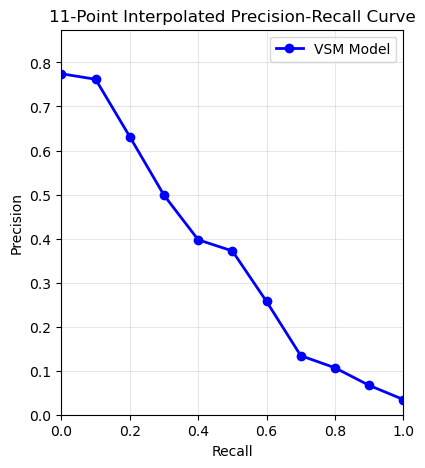

In [27]:
# Create visualization plots
plt.figure(figsize=(15, 5))

# Plot 1: 11-point interpolated precision-recall curve
plt.subplot(1, 3, 1)
recall_levels = np.arange(0.0, 1.1, 0.1)
plt.plot(recall_levels, vsm_results['interpolated_precisions'], 'bo-', 
         label='VSM Model', linewidth=2, markersize=6)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-Point Interpolated Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, max(vsm_results['interpolated_precisions']) + 0.1)



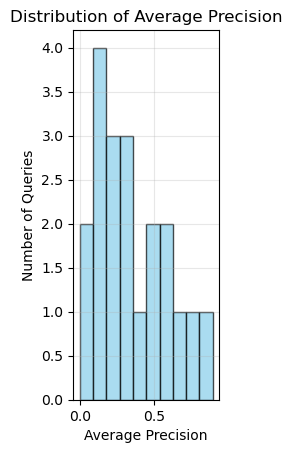

In [28]:
# Plot 2: Average Precision distribution
plt.subplot(1, 3, 2)
plt.hist(vsm_results['individual_aps'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Average Precision')
plt.ylabel('Number of Queries')
plt.title('Distribution of Average Precision')
plt.grid(True, alpha=0.3)



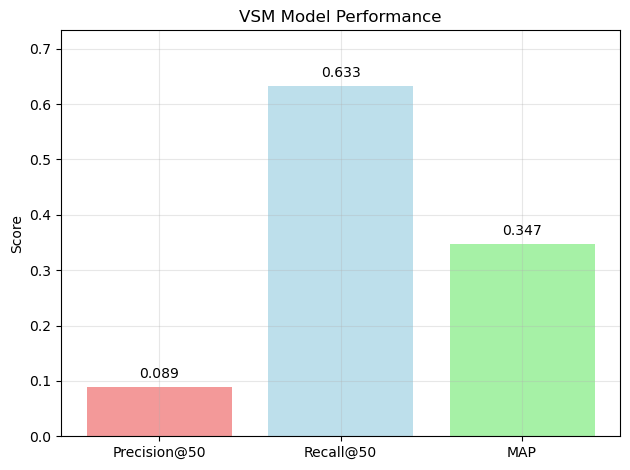


11-Point Interpolated Precision Values:
Recall | Precision
-------|----------
   0.0 |   0.7743
   0.1 |   0.7618
   0.2 |   0.6313
   0.3 |   0.4986
   0.4 |   0.3973
   0.5 |   0.3719
   0.6 |   0.2572
   0.7 |   0.1341
   0.8 |   0.1066
   0.9 |   0.0667
   1.0 |   0.0345

VSM EVALUATION COMPLETED


In [31]:
# Plot 3: Performance metrics bar chart
metrics = ['Precision@50', 'Recall@50', 'MAP']
values = [vsm_results['precision'], vsm_results['recall'], vsm_results['map']]
bars = plt.bar(metrics, values, alpha=0.8, color=['lightcoral', 'lightblue', 'lightgreen'])
plt.ylabel('Score')
plt.title('VSM Model Performance')
plt.ylim(0, max(values) + 0.1)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed interpolated precision values
print("\n11-Point Interpolated Precision Values:")
print("Recall | Precision")
print("-------|----------")
for i, recall in enumerate(recall_levels):
    precision = vsm_results['interpolated_precisions'][i]
    print(f"{recall:6.1f} | {precision:8.4f}")

print("\n" + "="*50)
print("VSM EVALUATION COMPLETED")
print("="*50)


In [30]:
# Detailed evaluation example with specific queries
print("=== DETAILED EVALUATION EXAMPLE ===")
print()

# Take first few queries for detailed analysis
sample_queries = dict(list(eval_queries.items())[:3])

for query_id, query_text in sample_queries.items():
    print(f"Query {query_id}: {query_text}")
    print(f"Relevant documents ({len(qrels[query_id])}): {qrels[query_id][:10]}")
    
    # Get results from VSM model
    vsm_results_sample = vsm_model.search(query_text, top_k=10)
    
    print("\nTop 5 VSM Results:")
    for i, result in enumerate(vsm_results_sample[:5]):
        doc_id = result['doc_id']
        similarity = result['similarity']
        is_relevant = "✓" if doc_id in qrels[query_id] else "✗"
        print(f"  {i+1}. Doc {doc_id} (sim: {similarity:.4f}) {is_relevant}")
    
    # Calculate precision@5 for this query
    vsm_relevant_at_5 = sum(1 for r in vsm_results_sample[:5] if r['doc_id'] in qrels[query_id])
    
    print(f"\nPrecision@5:")
    print(f"  VSM Model: {vsm_relevant_at_5}/5 = {vsm_relevant_at_5/5:.3f}")
    print("-" * 80)

print("\n=== SUMMARY ===")
print(f"Evaluation completed on 20 queries (subset)")
print(f"VSM Model MAP: {vsm_results['map']:.4f}")
print(f"VSM Model Precision@50: {vsm_results['precision']:.4f}")
print(f"VSM Model Recall@50: {vsm_results['recall']:.4f}")

# Test with a custom query
test_query = """longitudinal compression of simply supported rectangular plates with
several equally spaced transverse stiffeners that have both torsional
and flexural rigidity"""

print(f"\n=== CUSTOM QUERY TEST ===")
print(f"Test query: '{test_query}'")

vsm_test_results = vsm_model.search(test_query, top_k=5)
print(f"\nTop 5 VSM Results:")
for i, result in enumerate(vsm_test_results):
    doc_id = result['doc_id']
    similarity = result['similarity']
    doc_preview = documents[doc_id][:100] + "..."
    print(f"{i+1}. Doc {doc_id} (similarity: {similarity:.4f})")
    print(f"   Preview: {doc_preview}")
    print()


=== DETAILED EVALUATION EXAMPLE ===

Query 1: what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .
Relevant documents (29): ['184', '29', '31', '12', '51', '102', '13', '14', '15', '57']

Top 5 VSM Results:
  1. Doc 51 (sim: 0.3860) ✓
  2. Doc 486 (sim: 0.3613) ✓
  3. Doc 359 (sim: 0.2698) ✗
  4. Doc 12 (sim: 0.2647) ✓
  5. Doc 746 (sim: 0.2590) ✗

Precision@5:
  VSM Model: 3/5 = 0.600
--------------------------------------------------------------------------------
Query 2: what are the structural and aeroelastic problems associated with flight
of high speed aircraft .
Relevant documents (25): ['12', '15', '184', '858', '51', '102', '202', '14', '52', '380']

Top 5 VSM Results:
  1. Doc 12 (sim: 0.5777) ✓
  2. Doc 746 (sim: 0.3825) ✓
  3. Doc 51 (sim: 0.3737) ✓
  4. Doc 1169 (sim: 0.3140) ✗
  5. Doc 100 (sim: 0.2778) ✗

Precision@5:
  VSM Model: 3/5 = 0.600
------------------------------------------------------------------------------